# AAC feature evaluation (only Eukaryotes)

During the dataset evaluation, we found that E Coli transports form its own cluster in the PCA plot. How does the model perform without E Coli transporters?

# Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.eval import (
    get_independent_test_set,
    optimize_hyperparams,
    preprocess_pandas,
    models_quick_compare,
    get_confusion_matrix,
    get_classification_report,
    full_test
)
from subpred.compositions import calculate_aac
from subpred.plots import pca_plot_2d

# Dataset

In [2]:
outliers = (
    ["Q9HBR0", "Q07837"]  + ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
    
)
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    tax_ids_filter=[3702, 9606, 559292],
    output_log="../logs/meta_amino_sugar_dataset.log",
    outliers=outliers,
    sequence_clustering=70
)
taxid_to_organism = {
    3702: "A. thaliana",
    9606: "Human",
    559292: "Yeast",
}
df = df.assign(organism=df.organism_id.map(taxid_to_organism))


cd-hit: clustered 314 sequences into 249 clusters at threshold 70


# Feature generation

## Labels

In [3]:
labels = df.keywords_transport
labels.value_counts()

Sugar transport         134
Amino-acid transport    115
Name: keywords_transport, dtype: int64

## AAC

In [4]:
df_aac = calculate_aac(df.sequence)
df_aac

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
Uniprot,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.090730,0.015779,0.033531,0.035503,0.086785,0.088757,0.015779,0.092702,0.033531,0.104536,0.033531,0.033531,0.039448,0.029586,0.039448,0.055227,0.041420,0.086785,0.017751,0.025641
Q08986,0.085179,0.025554,0.027257,0.047700,0.069847,0.078365,0.010221,0.091993,0.044293,0.090290,0.018739,0.035775,0.032368,0.027257,0.035775,0.105622,0.044293,0.074957,0.017036,0.037479
Q9BRV3,0.058824,0.022624,0.031674,0.018100,0.058824,0.072398,0.009050,0.045249,0.022624,0.176471,0.027149,0.031674,0.040724,0.045249,0.045249,0.063348,0.072398,0.072398,0.027149,0.058824
Q84WN3,0.066390,0.004149,0.020747,0.053942,0.070539,0.074689,0.008299,0.070539,0.041494,0.120332,0.029046,0.033195,0.041494,0.016598,0.029046,0.087137,0.058091,0.103734,0.016598,0.053942
O04249,0.079922,0.013645,0.017544,0.042885,0.066277,0.107212,0.011696,0.076023,0.035088,0.120858,0.031189,0.038986,0.035088,0.035088,0.037037,0.064327,0.058480,0.081871,0.017544,0.029240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q94EI9,0.082353,0.014706,0.014706,0.041176,0.058824,0.064706,0.011765,0.088235,0.052941,0.132353,0.044118,0.044118,0.029412,0.011765,0.020588,0.073529,0.052941,0.105882,0.017647,0.038235
Q92536,0.073786,0.025243,0.029126,0.044660,0.069903,0.066019,0.011650,0.083495,0.027184,0.114563,0.021359,0.031068,0.052427,0.027184,0.034951,0.085437,0.058252,0.089320,0.015534,0.038835
F4IHS9,0.055556,0.017544,0.023392,0.017544,0.076023,0.064327,0.023392,0.067251,0.055556,0.154971,0.026316,0.046784,0.032164,0.035088,0.011696,0.093567,0.081871,0.084795,0.002924,0.029240


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

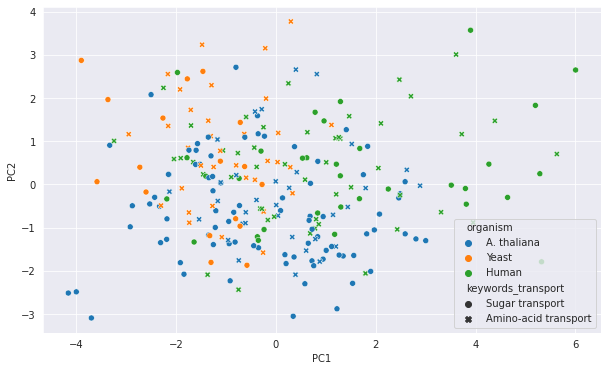

In [5]:
pca_plot_2d(df_aac, df.organism, df.keywords_transport)

### Independent test set

In [6]:
X, y, feature_names, sample_names = preprocess_pandas(
    df_aac, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)

### Model selection


In [8]:
models_quick_compare(X_train, y_train)

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.725,0.600,0.693,0.716,0.583,0.663,0.067
KNeighborsClassifier(),0.749,0.625,0.747,0.649,0.820,0.718,0.080
"LinearSVC(class_weight='balanced', max_iter=1000000.0, random_state=0)",0.749,0.573,0.699,0.688,0.717,0.685,0.067
"LinearSVC(max_iter=1000000.0, random_state=0)",0.693,0.599,0.699,0.710,0.690,0.678,0.045
"RandomForestClassifier(class_weight='balanced', random_state=0)",0.795,0.649,0.747,0.648,0.652,0.698,0.069
RandomForestClassifier(random_state=0),0.798,0.649,0.721,0.665,0.675,0.701,0.060
SGDClassifier(random_state=0),0.824,0.575,0.646,0.650,0.538,0.647,0.110
"SVC(class_weight='balanced', random_state=0)",0.900,0.693,0.774,0.740,0.820,0.785,0.079
SVC(random_state=0),0.850,0.670,0.774,0.763,0.794,0.770,0.065


### Parameter tuning

The linear model works considerably worse than *with* the E Coli transporters. The RBF kernel already looks better.

In [9]:
gsearch = optimize_hyperparams(X_train, y_train, kernel="linear")

{'linearsvc__C': 1, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': True, 'linearsvc__max_iter': 100000000.0}
0.685


In [10]:
gsearch = optimize_hyperparams(X_train, y_train, kernel="rbf", C=[0.1, 1, 10, 100])
best_estimator_svc = gsearch

{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.785


### Dimensionality reduction

Kbest does not improve the results my much, and removes four features (C, R, S, W)

In [7]:
gsearch = optimize_hyperparams(
    X_train, y_train, kernel="rbf", dim_reduction="kbest", C=[0.1, 1,10,100], gamma=["scale"]
)
best_estimator_svc_kbest = gsearch

{'selectkbest__k': 16, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.786


In [8]:
feature_names[~best_estimator_svc_kbest.best_estimator_["selectkbest"].get_support()]

array(['C', 'R', 'S', 'W'], dtype='<U1')

The amino acid whose removal improves the model is Glu.

PCA performs worse, which might be caused by the fact that it removes more information to reach 99% of variance explained:

In [13]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    C=[0.1, 1, 10, 100],
    gamma=["scale", 1, 0.1, 0.01, 0.001],
)
best_estimator_svc_pca = gsearch

{'pca__n_components': 0.97, 'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.751


### Validation

Kbest had a slightly worse performance on the training set than PCA, and a much better performance on the test set.The performance of the model without feature selection is between that of PCA and Kbest.

#### Kbest

In [14]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_kbest, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,19,4
Sugar transport,7,20


In [15]:
get_classification_report(X_test, y_test, best_estimator_svc_kbest, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.731,0.826,0.776,23
Sugar transport,0.833,0.741,0.784,27
macro avg,0.782,0.783,0.780,50
weighted avg,0.786,0.780,0.780,50


#### No feature selection:

In [16]:
get_confusion_matrix(X_test, y_test, best_estimator_svc, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,20,3
Sugar transport,7,20


In [17]:
get_classification_report(X_test, y_test, best_estimator_svc, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.741,0.870,0.8,23
Sugar transport,0.870,0.741,0.8,27
macro avg,0.805,0.805,0.8,50
weighted avg,0.810,0.800,0.8,50


#### PCA

In [18]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_pca, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,19,4
Sugar transport,8,19


In [19]:
get_classification_report(X_test, y_test, best_estimator_svc_pca, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.704,0.826,0.76,23
Sugar transport,0.826,0.704,0.76,27
macro avg,0.765,0.765,0.76,50
weighted avg,0.770,0.760,0.76,50


## Checking dependence on train test split


### Kbest model

On average, the model performs about as good as on the split above:

In [20]:
df_scores, df_params = full_test(
    df_aac, labels, dim_reduction="kbest", kernel="rbf", repetitions=10
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .mean()
    .pivot(index="label", columns="dataset", values="F1 score")
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .std()
    .pivot(index="label", columns="dataset", values="F1 score")
)

dataset,test,train
label,,
Amino-acid transport,0.7574,0.8106
Sugar transport,0.7950,0.8303


dataset,test,train
label,,
Amino-acid transport,0.076635,0.023282
Sugar transport,0.045505,0.015305


#### PCA

As before, the PCA model delivers worse results than Kbest:

In [21]:
df_scores, df_params = full_test(
    df_aac, labels, dim_reduction="pca", kernel="rbf", repetitions=10
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .mean()
    .pivot(index="label", columns="dataset", values="F1 score")
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .std()
    .pivot(index="label", columns="dataset", values="F1 score")
)

dataset,test,train
label,,
Amino-acid transport,0.6893,0.796
Sugar transport,0.7377,0.826


dataset,test,train
label,,
Amino-acid transport,0.102366,0.047826
Sugar transport,0.072094,0.031503


### All features

Interestingly, the average performance is actually better on average without feature selection. The removal of Glu improving scores might have been something that was only the case in our split.  

In [22]:
df_scores, df_params = full_test(
    df_aac, labels, kernel="rbf", repetitions=10
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .mean()
    .pivot(index="label", columns="dataset", values="F1 score")
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .std()
    .pivot(index="label", columns="dataset", values="F1 score")
)
df_params

dataset,test,train
label,,
Amino-acid transport,0.7741,0.8061
Sugar transport,0.8109,0.8264


dataset,test,train
label,,
Amino-acid transport,0.076638,0.032206
Sugar transport,0.053602,0.021578


,0,1,2,3,4,5,6,7,8,9
svc__C,1,10,1,1,1,1,1,1,10,1
svc__class_weight,balanced,balanced,balanced,None,balanced,balanced,balanced,None,balanced,balanced
svc__gamma,0.1,scale,0.1,0.1,0.1,scale,scale,0.1,0.1,0.1


## Conclusion

As without E Coli, the AAC works best with all amino acids in the feature dataset. Removing the prokaryotic transporters did not lead to a clear improvement of the model. 